`TODO`: convert everything to real (micron) scale before computations

In [2]:
# Where to find the data and simulation output
DATA_DIR = 'data/current_sim/'

First import a bunch of data which gets used repeatedly.

In [3]:
# Import grid data

from __future__ import division
import itertools
import yaml

with open(DATA_DIR + '/grid.txt') as f:
    grid = yaml.load(f)

#num_electrodes = grid['num_electrodes']
num_electrodes = grid['num_electrodes']
    
grid_dims = (grid['dimx'], grid['dimy'], grid['dimz'])

grid_lens = (grid['endx'] - grid['startx'], grid['endy'] - grid['starty'], grid['endz'] - grid['startz'])

grid_ax_pts = (np.linspace(grid['startx'], grid['endx'], grid_dims[0]),
               np.linspace(grid['starty'], grid['endy'], grid_dims[1]),
               np.linspace(grid['startz'], grid['endz'], grid_dims[2]))

num_pts = grid_dims[0] * grid_dims[1] * grid_dims[2]

grid_delta = map(lambda (length, dim): length / (dim - 1), zip(grid_lens, grid_dims))

#def grid_index(i, j, k):
#    return i * grid_dims[2] * grid_dims[1] + j * grid_dims[2] + k

def grid_point(i, j, k):
    return (grid_ax_pts[0][i], grid_ax_pts[1][j], grid_ax_pts[2][k])

# Iterate over all grid points in the order of the computed data
def grid_pts():
    for i, j, k in itertools.product(*map(range, grid_dims)):
        yield (grid_ax_pts[0][i], grid_ax_pts[1][j], grid_ax_pts[2][k])

This function is just for plotting purposes.

In [26]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from mpl_toolkits.mplot3d import Axes3D

def plot_data(dat, k=None, vmin=0, vmax=1, title='Potential', levels=10):
    v = np.linspace(vmin, vmax, levels)
    
    if k is None:
        k = map(lambda x: x // 2, grid_dims)
    
    X1, Y1 = np.meshgrid(grid_ax_pts[0], grid_ax_pts[1], indexing="ij")
    Y2, Z2 = np.meshgrid(grid_ax_pts[1], grid_ax_pts[2], indexing="ij")
    X3, Z3 = np.meshgrid(grid_ax_pts[0], grid_ax_pts[2], indexing="ij")
    val1 = dat[:, :, k[2]]
    val2 = dat[k[0], :, :]
    val3 = dat[:, k[1], :]

    # Render data
    
    fig = plt.figure(figsize=(14, 8))
    
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.set_title(title + ' (z = {})'.format(grid_ax_pts[2][k[0]]))
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.contourf(X1, Y1, val1, v, vmin=vmin, vmax=vmax, cmap=get_cmap('bone'), extend='both')

    ax2 = fig.add_subplot(2, 2, 2)
    ax2.set_title(title + ' (x = {})'.format(grid_ax_pts[0][k[1]]))
    ax2.set_xlabel('y')
    ax2.set_ylabel('z')
    ax2.contourf(Y2, Z2, val2, v, vmin=vmin, vmax=vmax, cmap=get_cmap('bone'), extend='both')

    ax3 = fig.add_subplot(2, 2, 3)
    ax3.set_title(title + ' (y = {})'.format(grid_ax_pts[2][k[2]]))
    ax3.set_xlabel('x')
    ax3.set_ylabel('z')
    cnt = ax3.contourf(X3, Z3, val3, v, vmin=vmin, vmax=vmax, cmap=get_cmap('bone'), extend='both')
    
    cbar = fig.colorbar(cnt, ax=[ax1, ax2, ax3])
    cbar.set_label('Potential (V)')
    
    return fig

Import the electrode data created by BemSolver.

In [19]:
# Import electrode data

from glob import glob
import numpy as np

# Potential array; each column is an electrode and row a grid point
a = np.zeros((num_pts, num_electrodes))

for i in range(1, num_electrodes + 1):
    a[:,i - 1] = np.loadtxt(DATA_DIR + '/field{}.txt'.format(i))

ELECTRODE = 3
#plot_data(a[:,ELECTRODE].reshape(grid_dims), vmin=0, vmax=0.04, title='Electrode ' + str(ELECTRODE));

We need some target potential to fit the electrodes to, e.g. a quartic with maximum value of 100 mV.

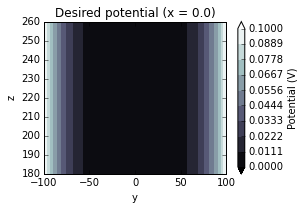

In [24]:
from __future__ import division

b = np.zeros(num_pts)

def phi(x, y, z):
    return 0.1 * (2 * (y - grid_ax_pts[1][grid_dims[1] // 2]) / grid_lens[1])**4

for i, p in enumerate(grid_pts()):
    b[i] = phi(*p)
    
plot_data(b.reshape(grid_dims), vmax=0.1, title='Desired potential');

Now we find the constrained least squares fit of the DC electrode voltages to the target potential. Ensure that each voltage lie between -40 V and 40 V.

[-40.00130937  -2.38593307  40.00069856  15.57205827 -40.00164699
 -40.00162448  15.12868949  40.00069369  -2.06431    -40.00129044]


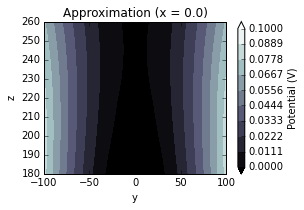

In [25]:
from scipy.optimize import leastsq

# This is how we add inequality constraints
def tub(a, b, w):
    return lambda x: w * max(-x + a, 0, x - b)

def residuals(p):
    return np.concatenate((b - np.dot(a, p[:num_electrodes]), map(tub(-40, 40, 1), p)))

#V = np.linalg.solve(np.dot(a.T, a), np.dot(a.T, b))
V = leastsq(residuals, np.zeros(2 * num_electrodes))[0][:num_electrodes]
print(V)

pot = np.dot(a, V)

# Export potential along trapping axis
trap_pot = pot[grid_dims[0] // 2, :, grid_dims[2] // 2]
np.savetxt(DATA_DIR + '/axis.txt', trap_pot)

plot_data(pot.reshape(grid_dims), vmax=0.1, title='Approximation');

Next, we take a look at the RF potential.

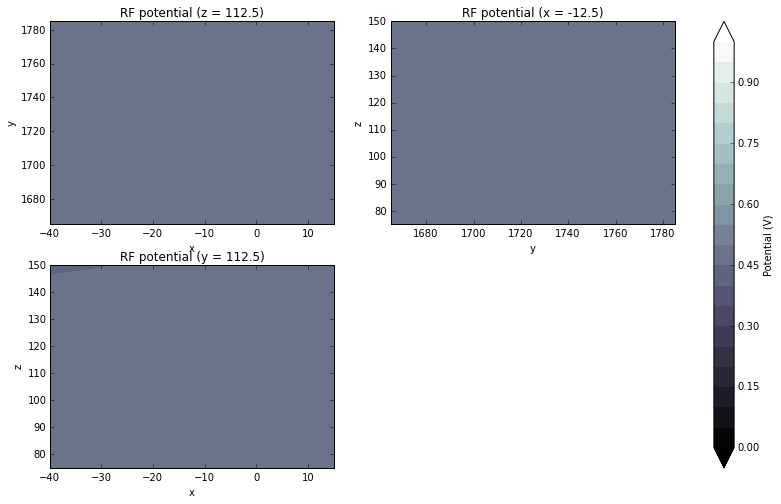

In [6]:
rf = np.loadtxt(DATA_DIR + 'field0.txt').reshape(grid_dims)
plot_data(rf, vmin=0, vmax=1, levels=21, title='RF potential');

To find the trapping region of the potential, we calculate the ponderomotive pseudopotential generated by the RF electrode. The pseudopotential in 3D is given by

$$U = \frac{Q^2}{2 m \Omega^2} |\mathbf E|^2,$$

where $Q$ is the ion charge, $m$ the ion mass, and $\Omega$ is the angular frequency of the RF.

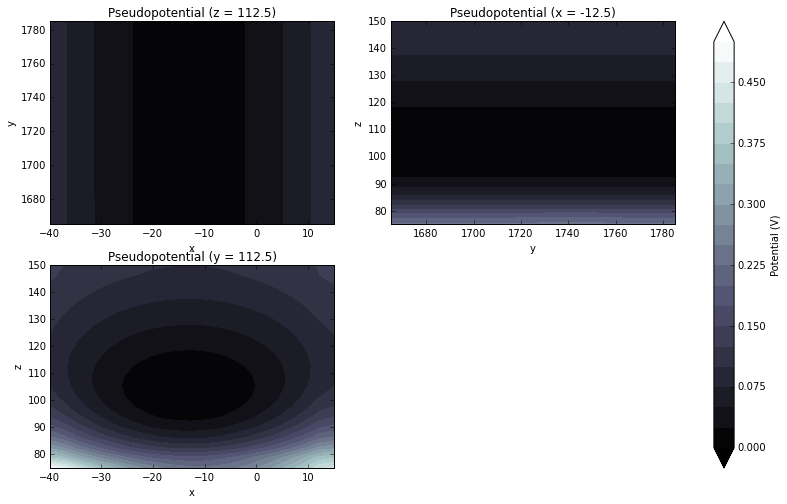

In [7]:
import math
import scipy.constants

# Constants for Ca40+
mass = 40 * scipy.constants.m_p
charge = scipy.constants.e
freq = 2 * math.pi * 40e6
rf_level = 100

scale = 1e-6

# Calculate pseudopotential for the RF, assuming dimensions are microns
ex, ey, ez = np.gradient(rf_level * rf, grid_delta[0] * scale, grid_delta[1] * scale, grid_delta[2] * scale)
pseudo_phi = charge / (2 * mass * freq * freq) * (ex * ex + ey * ey + ez * ez)

plot_data(pseudo_phi, vmin=0, vmax=0.5, levels=21, title='Pseudopotential');

To get a fair estimate of the trap axis position, assume it lies in the plane $x = 0$ and minimize the pseudopotential on the vertical axis (using Newton's method).

Approximate trap axis z is 219.999998857


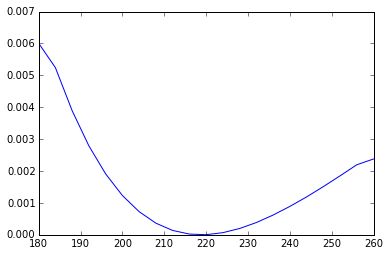

In [11]:
# Use Newton's method to get a simple, 1D estimate of trap axis position

from scipy.interpolate import interp1d

v = pseudo_phi[grid_dims[0] // 2, grid_dims[1] // 2, :]

plot(grid_ax_pts[2], v, 'b-')

ez_int = interp1d(grid_ax_pts[2], ez[grid_dims[0] // 2, grid_dims[1] // 2, :])
ezz = np.gradient(ez[grid_dims[0] // 2, grid_dims[1] // 2, :], grid_delta[2] * scale)
ezz_int = interp1d(grid_ax_pts[2], ezz)

epsilon = 1
z = grid_ax_pts[2][grid_dims[2] // 2]
d = float('+inf')
while d > epsilon:
    z1 = z - float(ez_int(z)) / float(ezz_int(z))
    d = abs(z - z1)
    z = z1

print('Approximate trap axis z is ' + str(z))

Here we attempt to find the trapping axis (the saddle point) by finding the minimum of the ponderomotive pseudopotential of the RF electrode. Once this has been found, the target voltages can be refined using a narrower grid around the predicted axis

Approximate trapping axis is [ -2.09498869e-09   2.20000000e+02]


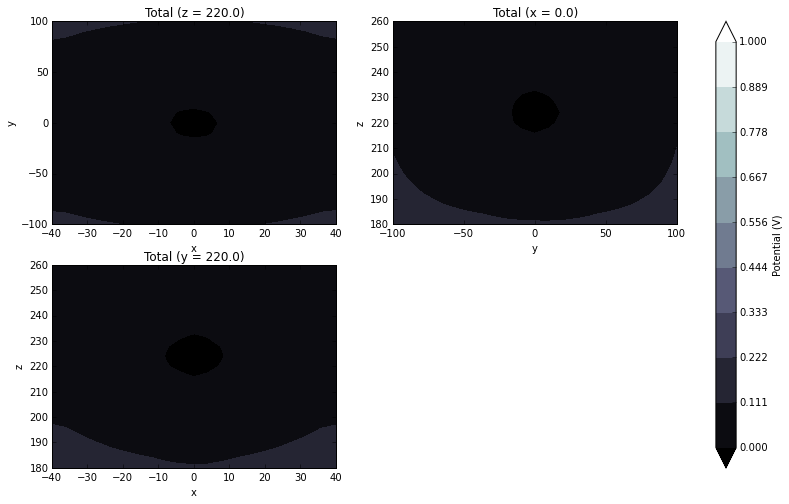

In [38]:
# Writing Newton's method myself was a terrible idea and scipy.optimize should be used in the future

from scipy.interpolate import RegularGridInterpolator

u = pseudo_phi + pot.reshape(grid_dims)

plot_data(u, vmin=0, vmax=1, title='Total');

# Go team functional!
def scale_to_grid(x):
    return map(lambda (i, x): (x - grid_ax_pts[i][0]) / grid_lens[i] * (grid_dims[i] - 1), ((0, x[0]), (2, x[1])))

def snap(x):
    return map(lambda y: int(y + 0.5), x)

#def clamp(mn, mx, x):
#    return map(lambda mn, mx, x: max(min(x, mn), mx), zip(mn, mx, x))

def to_grid_idx(x):
    return snap(scale_to_grid(x))

# Run Newton's method for simultaneous zeros
# Code is slow but method is fast in 2D
epsilon = 0.01
k = grid_dims[1] // 2

# Linearly. Interpolate. Everything.
axes = (grid_ax_pts[0], grid_ax_pts[2])
u_int = RegularGridInterpolator(axes, u[:,k,:])
ex_int = RegularGridInterpolator(axes, ex[:,k,:])
ez_int = RegularGridInterpolator(axes, ez[:,k,:])
exx, exz = np.gradient(ex[:,k,:], grid_delta[0] * scale, grid_delta[2] * scale)
ezx, ezz = np.gradient(ez[:,k,:], grid_delta[0] * scale, grid_delta[2] * scale)
exx_int = RegularGridInterpolator(axes, exx)
exz_int = RegularGridInterpolator(axes, exz)
ezx_int = RegularGridInterpolator(axes, ezx)
ezz_int = RegularGridInterpolator(axes, ezz)

x = np.array([grid_ax_pts[0][grid_dims[0] // 2], grid_ax_pts[2][grid_dims[2] // 2]])
h = grid_lens[0] / (grid_dims[0] - 1)
k = grid_lens[2] / (grid_dims[2] - 1)
d = float('+inf')
while d > epsilon:
    E = np.array([float(ex_int(x)), float(ez_int(x))])
    
    # Jacobian of the potential gradient
    J = np.array([[float(exx_int(x)), float(exz_int(x))], [float(ezx_int(x)), float(ezz_int(x))]])
    Jinv = np.linalg.inv(J)
    
    x1 = x - np.dot(Jinv, E)
    
    dx = x1 - x
    d = float(np.dot(dx, dx))
    
    x = x1

print('Approximate trapping axis is ' + str(x))